In [1]:

from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [2]:
![picture](https://drive.google.com/open?id=1DzQugTJyUpDSHWO7KL6SUCZsjEAqPm1i)



/bin/bash: -c: line 0: syntax error near unexpected token `https://drive.google.com/open?id=1DzQugTJyUpDSHWO7KL6SUCZsjEAqPm1i'
/bin/bash: -c: line 0: `[picture](https://drive.google.com/open?id=1DzQugTJyUpDSHWO7KL6SUCZsjEAqPm1i)'


In [3]:
from google.colab import files

In [4]:
import numpy as np
from imageio import imread
import cv2

import torch
import torch.nn
from torchvision.models.vgg import vgg19

import matplotlib.pyplot as plt
%matplotlib inline
!pip install sporco
!pip install flirimageextractor


     |████████████████████████████████| 4.5 MB 8.3 MB/s 
     |████████████████████████████████| 2.6 MB 38.7 MB/s 


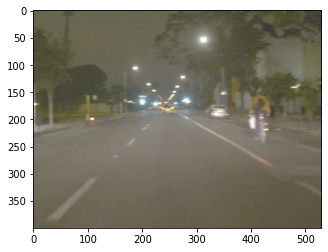

In [5]:
idx = 1
gray = imread('https://drive.google.com/uc?id=1gaH75Gk77tTso7G3aACRMCnfpVUT6ah0')


# resize image
img1 = cv2.resize(gray, (640,512))
ir = imread('https://drive.google.com/uc?id=1idzVDHFg_VxSsvSy5sCzP0kQc2khHwdQ')

from PIL import Image



image = cv2.imread('img1')
import cv2

import tensorflow as tf
offset_height=50
offset_width=70
target_height=400
target_width= 530
img1 = tf.image.crop_to_bounding_box(
    img1, offset_height, offset_width, target_height, target_width
)

tf.keras.preprocessing.image.array_to_img(
    img1, data_format=None, scale=True, dtype=None
)
plt.imshow(img1)



In [6]:
imgUMat = np.float32(img1)
gray = cv2.cvtColor(np.float32(imgUMat), cv2.COLOR_RGB2GRAY)
cv2.waitKey(1000)
gray = cv2.resize(gray, (640,512))

In [7]:
%cd gdrive/MyDrive/Colab Notebooks



/content/gdrive/MyDrive/Colab Notebooks


In [8]:

import sys
sys.path.append('./')
import vgg

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


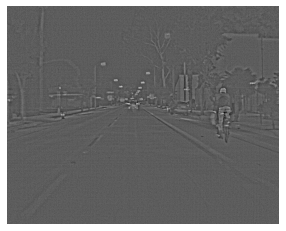

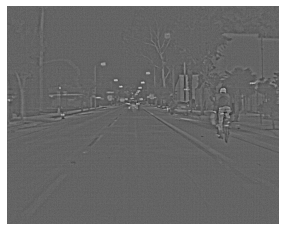

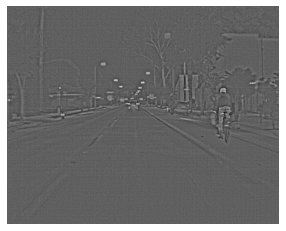

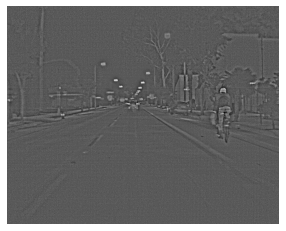

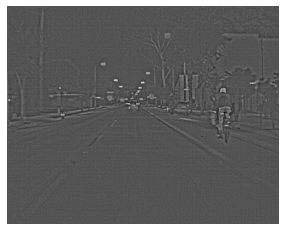

In [9]:
from vgg import *

plt.imshow(gray)
plt.imshow(ir)

npad = 16
lda = 5
graylow, grayhigh = lowpass(gray.astype(np.float32)/255, lda, npad)
irlow, irhigh = lowpass(ir.astype(np.float32)/255, lda, npad)

grayhigh3 = c3(grayhigh)
irhigh3 = c3(irhigh)

model = vgg19(True).cuda().eval()

gray_in = torch.from_numpy(grayhigh3).cuda()
ir_in = torch.from_numpy(irhigh3).cuda()
relus = [2, 7, 12, 21]
unit_relus = [1, 2, 4, 8]

relus_gray = get_activation(model, relus, gray_in)
relus_ir = get_activation(model, relus, ir_in)

gray_feats = [l1_features(out) for out in relus_gray]
ir_feats = [l1_features(out) for out in relus_ir]

saliencies = []
saliency_max = None
for idx in range(len(relus)):
    saliency_current = fusion_strategy(gray_feats[idx], ir_feats[idx], grayhigh, irhigh, unit_relus[idx])
    saliencies.append(saliency_current)
    
    if saliency_max is None:
        saliency_max = saliency_current
    else:
        saliency_max = np.maximum(saliency_max, saliency_current)
    
    plt.imshow(saliency_current, 'gray')
    plt.axis('off')
    plt.show()

plt.imshow(saliency_max, 'gray')
plt.axis('off')
plt.show()

Text(0.5, 1.0, 'Fusion')

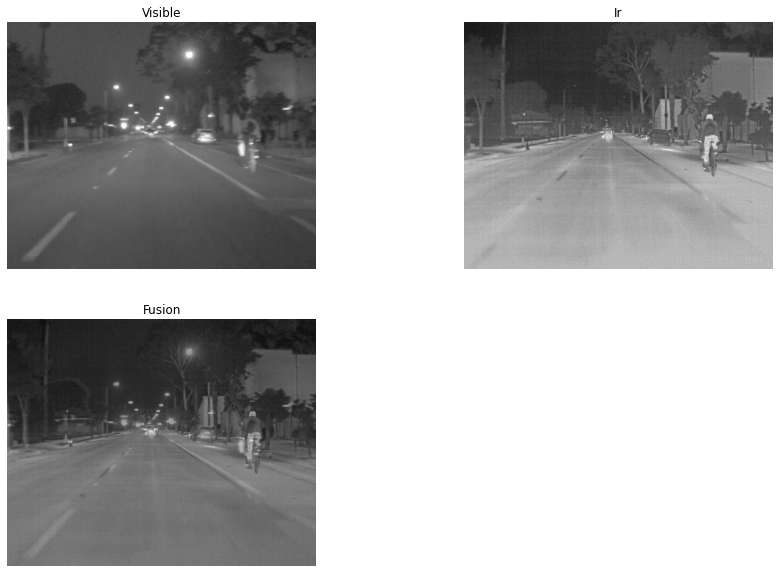

In [ ]:
low_fused = (graylow + irlow) / 2
high_fused = saliency_max

fusion = low_fused + high_fused

plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
plt.imshow(gray, 'gray')
plt.axis('off')
plt.title('Visible')

plt.subplot(2, 2, 2)
plt.imshow(ir, 'gray')
plt.axis('off')
plt.title('Ir')

plt.subplot(2, 2, 3)
plt.imshow(fusion, 'gray')
plt.axis('off')
plt.title('Fusion')